In [1]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_9a9180f8805e441680fa6185f15bcc74 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='1hhgENbDUtyvwgy31yKbcwtul7dapZ36lBWzXgI5gkGu',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_9a9180f8805e441680fa6185f15bcc74.get_object(Bucket='default-donotdelete-pr-3awffskzsknttl',Key='titanic.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Cleaning

First find all columns with missing values.

In [2]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Handle missing age numbers by finding median age values for male and female and inputting them into the missing elements in the age column.

In [3]:
bysexclass = df.groupby(['Sex', 'Pclass'])

def impute_median(series):
    return series.fillna(series.median())

In [4]:
df.age = bysexclass['Age'].transform(impute_median)
print(df.tail(10))

     PassengerId  Survived  Pclass                                      Name  \
881          882         0       3                        Markun, Mr. Johann   
882          883         0       3              Dahlberg, Miss. Gerda Ulrika   
883          884         0       2             Banfield, Mr. Frederick James   
884          885         0       3                    Sutehall, Mr. Henry Jr   
885          886         0       3      Rice, Mrs. William (Margaret Norton)   
886          887         0       2                     Montvila, Rev. Juozas   
887          888         1       1              Graham, Miss. Margaret Edith   
888          889         0       3  Johnston, Miss. Catherine Helen "Carrie"   
889          890         1       1                     Behr, Mr. Karl Howell   
890          891         0       3                       Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked  
881    male  33.0      0      0            

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':


For Embarkment, fill the missing values with the most common element which from data visualisation was shown to be S. I shall then transfor the data into integers with S = 1, Q = 1 and S = 2. I shall save this information as a new column in dataframe with "g" in front.

In [5]:
df['Embarked'].fillna('S', inplace=True)
df['gembark'] = df['Embarked'].apply(lambda x: 0 if (x == 'C') else 1 if (x == 'Q') else 2)


Transform the sex data into binary values for analysis.

In [6]:
df['gsex'] = df['Sex'].apply(lambda x: 1 if (x == 'female') else 0)

For Cabins, too much information is missing to make a predictive model to estimate other cabin numbers therefore for this project I will not be considering cabin rows and numbers.

# Exploratory Data Analysis and Visualisation

In [7]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,gembark,gsex
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.536476,0.352413
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.791503,0.477990
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.000000,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,2.000000,0.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,2.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,2.000000,1.000000


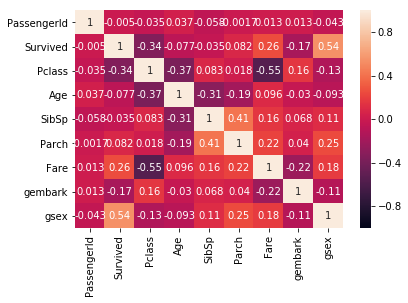

In [41]:
sns.heatmap(df.corr(),annot=True,vmin=-1,vmax=1)

From the analysis above we can see that roughly 38% of the passengers survived and there is evidence of correlation between survival and class,fare,age and gender according to the correlation matrix table. Below are further visualisations of the data set.

In [9]:
Age_df= []
Survived_yes= []
Survived_no= []
age = 1
while age < 81:
    x = df.loc[df["Age"] == age]
    y = x.loc[x["Survived"] == 1]
    y1 = y["Survived"].count()
    z = x.loc[x["Survived"] == 0]
    z1 = z["Survived"].count()
    Age_df.append(age)
    Survived_yes.append(y1)
    Survived_no.append(z1)
    age = age + 1

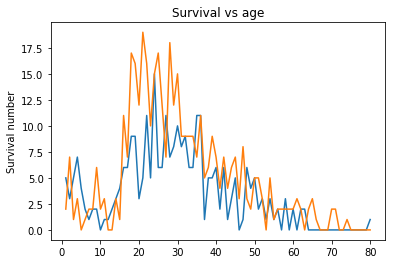

In [10]:
x_coordinates = Age_df

y1_coordinates = Survived_yes
y2_coordinates = Survived_no

fig, ax = plt.subplots()
ax.set_ylabel('Survival number')
ax.set_title('Survival vs age')


plt.plot(x_coordinates, y1_coordinates, label ='survived')

plt.plot(x_coordinates, y2_coordinates, label = "not survived")

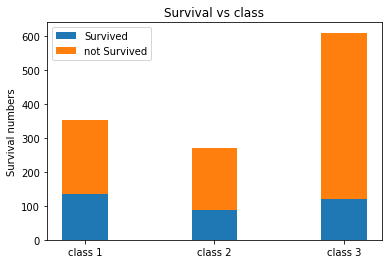

In [11]:
x3 = [136, 87, 119]
y3 = [216, 184, 491]
N = 3
ind = np.arange(N)    
width = 0.35       
p1 = plt.bar(ind, x3, width)
p2 = plt.bar(ind, y3, width,
             bottom= x3)

plt.ylabel('Survival numbers')
plt.title('Survival vs class')
plt.xticks(ind, ('class 1', 'class 2', 'class 3' ))
plt.legend((p1[0], p2[0]), ('Survived', 'not Survived'))

plt.show()

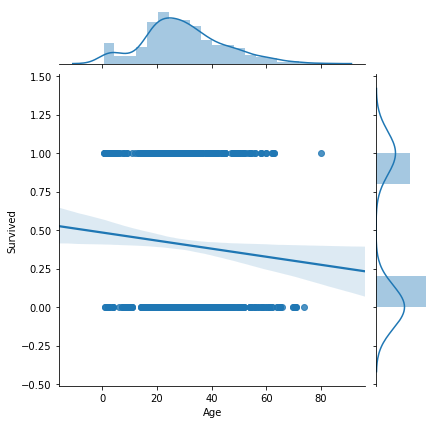

In [12]:
sns.jointplot(x="Age" ,y="Survived",data=df,kind="reg")

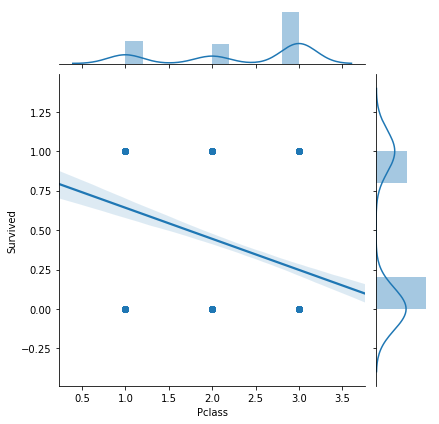

In [13]:
sns.jointplot(x="Pclass" ,y="Survived",data=df,kind="reg")

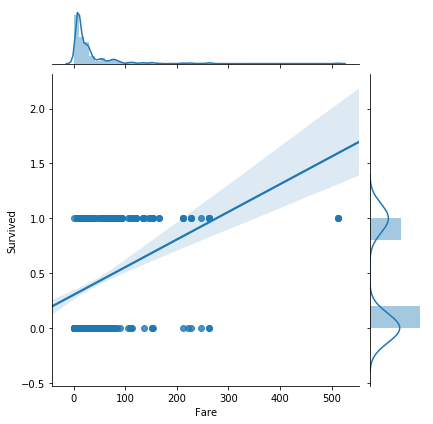

In [14]:
sns.jointplot(x="Fare" ,y="Survived",data=df,kind="reg")

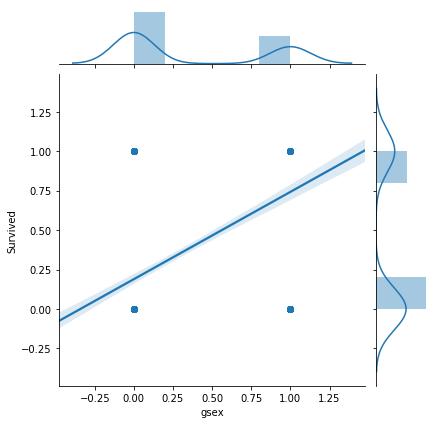

In [21]:
sns.jointplot(x="gsex" ,y="Survived",data=df,kind="reg")

# Prepare training and test set

In [79]:
y = df["Survived"]
X = df.filter(['Pclass','Fare','Age',"gembark","gsex"], axis=1)
X_train,X_test,y_train,y_test = train_test_split(X.index,y,test_size=0.2)
X_train= X_train.values.reshape(-1,1)
y_train= y_train.values.reshape(-1,1)
X_test= X_test.values.reshape(-1,1)
y_test= y_test.values.reshape(-1,1)

# Multivariate linear regression model

In [80]:
from sklearn import linear_model
from sklearn import datasets

lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)

In [81]:
predictions = lm.predict(X_train)
#print(predictions)[0:5]

In [82]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)

In [83]:
value = y_pred - y_test
value.mean()

0.06846795491055362

In [88]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test.round(), y_pred.round(), normalize=False)

120

# LSTM model

In [102]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM

In [103]:
model = Sequential()

In [104]:
model.add( Embedding(output_dim=32, input_dim=2000, input_length=1) )
model.add( Dropout(0.35) )

In [105]:
model.add( LSTM(units=16) )
model.add( Dense(units=256, activation='relu') )
model.add( Dropout(0.5) )
model.add( Dense(units=1, activation='sigmoid') )

In [106]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 1, 32)             64000     
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_11 (Dense)             (None, 256)               4352      
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 71,745
Trainable params: 71,745
Non-trainable params: 0
_________________________________________________________________


In [107]:
model.compile( loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'] )

In [108]:
import numpy as np
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_train = X_train[:, :, 0]

In [109]:
train_data = model.fit( X_train, y_train, batch_size=100, epochs=10, verbose=2, validation_split=0.2)

Train on 569 samples, validate on 143 samples
Epoch 1/10
 - 12s - loss: 0.6913 - acc: 0.6151 - val_loss: 0.6898 - val_acc: 0.5734
Epoch 2/10
 - 9s - loss: 0.6853 - acc: 0.6098 - val_loss: 0.6862 - val_acc: 0.5734
Epoch 3/10
 - 10s - loss: 0.6784 - acc: 0.6098 - val_loss: 0.6836 - val_acc: 0.5734
Epoch 4/10
 - 10s - loss: 0.6737 - acc: 0.6098 - val_loss: 0.6822 - val_acc: 0.5734
Epoch 5/10
 - 11s - loss: 0.6674 - acc: 0.6098 - val_loss: 0.6821 - val_acc: 0.5734
Epoch 6/10
 - 11s - loss: 0.6635 - acc: 0.6098 - val_loss: 0.6832 - val_acc: 0.5734
Epoch 7/10
 - 10s - loss: 0.6575 - acc: 0.6098 - val_loss: 0.6848 - val_acc: 0.5734
Epoch 8/10
 - 10s - loss: 0.6433 - acc: 0.6098 - val_loss: 0.6861 - val_acc: 0.5734
Epoch 9/10
 - 10s - loss: 0.6285 - acc: 0.6098 - val_loss: 0.6866 - val_acc: 0.5734
Epoch 10/10
 - 9s - loss: 0.6015 - acc: 0.6098 - val_loss: 0.6850 - val_acc: 0.5734


In [110]:
y_test = np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1]))
X_test = X_test[:, :, 0]
y_test = y_test[:, :, 0]
scores = model.evaluate( X_test, y_test, verbose=1 )
print(scores[1])

179/179 [==============================] - 1s 7ms/step
0.6703910627844614


In [111]:
y_pred = model.predict_classes(X_test)

In [78]:
predict[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [113]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test.round(), y_pred.round(), normalize=False)

120